In [34]:
import numpy as np
import matplotlib.pyplot as plt
import sys
if "../" not in sys.path:
  sys.path.append("../src/")
import reduction
import matplotlib
%matplotlib inline 

In [35]:
# read SP500 data
SP500 = np.genfromtxt('../data/SP500array.csv', delimiter=',')
SP500 = SP500.T
nStock = len(SP500[:,0])
nTime = len(SP500[0,:])

# preprocessing, subtract each stock price mean and normalize by std
x = np.copy(SP500)
for i in range(nStock):
    x[i,:] = (x[i,:] - np.mean(x[i,:]))/np.std(x[i,:])

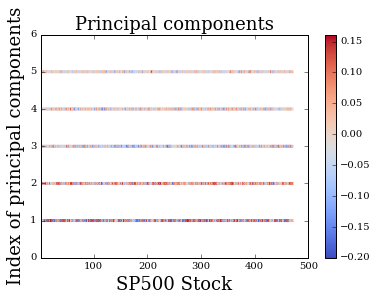

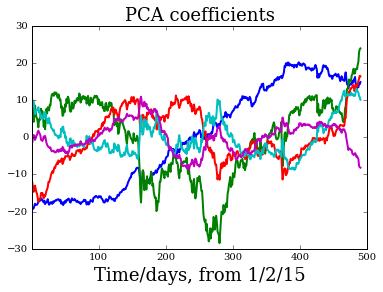

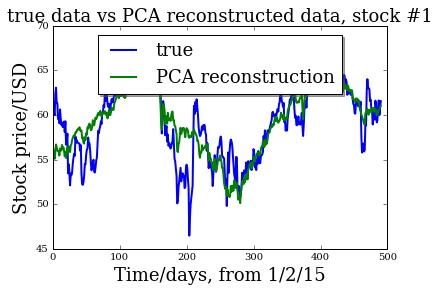

In [36]:
# call and test PCA
n_components = 5
SPreduction = reduction.Reduction(x)
ux, at, energy_content = SPreduction.PCA(n_components)
# PCA compressed data
xPCA = ux.dot(at)

# plot principal components
plt.figure()
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(n_components):
    plt.scatter(range(1,nStock+1),(i+1)*np.ones(nStock),c=ux[:,i], 
                marker='x', s=5, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlim([1,500])
plt.ylim([0,n_components+1])
plt.xlabel('SP500 Stock', fontsize=18)
plt.ylabel('Index of principal components', fontsize=18)
plt.title('Principal components', fontsize=18)
plt.show()

# plot principal coefficient
plt.figure()
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(n_components):
    plt.plot(range(1,nTime+1), at[i,:],'-',linewidth=2)
plt.xlim([1,500])
plt.xlabel('Time/days, from 1/2/15', fontsize=18)
plt.title('PCA coefficients', fontsize=18)
plt.show()

# plot SP500 and PCA predictions for the first Stock
stockIndex = 1
stockMean = np.mean(SP500[stockIndex,:])
stockStd = np.std(SP500[stockIndex,:])
plt.figure()
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(range(1,nTime+1), stockMean + stockStd*x[stockIndex,:],'-',linewidth=2,label='true')
plt.plot(range(1,nTime+1), stockMean + stockStd*xPCA[stockIndex,:],'-',linewidth=2,label='PCA reconstruction')
plt.xlabel('Time/days, from 1/2/15', fontsize=18)
plt.ylabel('Stock price/USD', fontsize=18)
plt.title('true data vs PCA reconstructed data, stock #1', fontsize=18)
plt.legend(loc='upper center', shadow=True, fontsize=18)
plt.show()

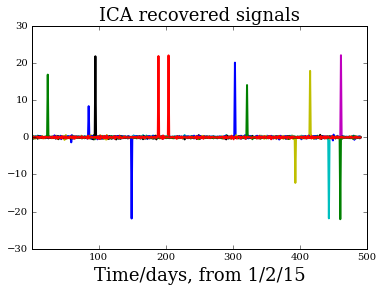

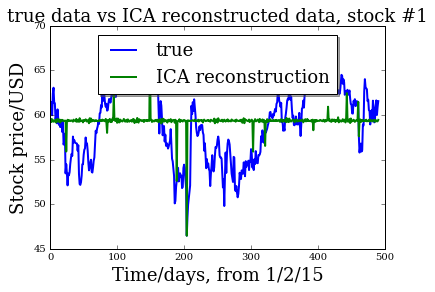

In [37]:
# call and test ICA
n_components = 10
SPreduction = reduction.Reduction(x)
Ex, T, A, W, S = SPreduction.ICA(n_components)

# reconstructed data with 10 ICA components
xtilde = A.dot(S)
xICA = np.linalg.inv(T).dot(xtilde)

# plot independent signals
plt.figure()
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(n_components):
    plt.plot(range(1,nTime+1), S[i,:],'-',linewidth=2)
plt.xlim([1,500])
plt.xlabel('Time/days, from 1/2/15', fontsize=18)
plt.title('ICA recovered signals', fontsize=18)
plt.show()

# plot SP500 and ICA predictions for the first Stock
stockIndex = 1
stockMean = np.mean(SP500[stockIndex,:])
stockStd = np.std(SP500[stockIndex,:])
plt.figure()
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(range(1,nTime+1), stockMean + stockStd*x[stockIndex,:],'-',linewidth=2,label='true')
plt.plot(range(1,nTime+1), stockMean + stockStd*xICA[stockIndex,:],'-',linewidth=2,label='ICA reconstruction')
plt.xlabel('Time/days, from 1/2/15', fontsize=18)
plt.ylabel('Stock price/USD', fontsize=18)
plt.title('true data vs ICA reconstructed data, stock #1', fontsize=18)
plt.legend(loc='upper center', shadow=True, fontsize=18)
plt.show()


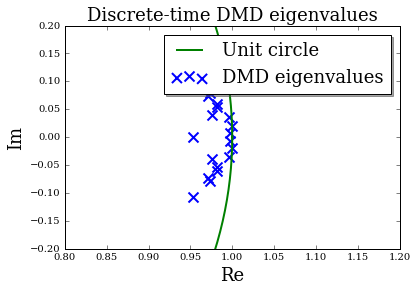

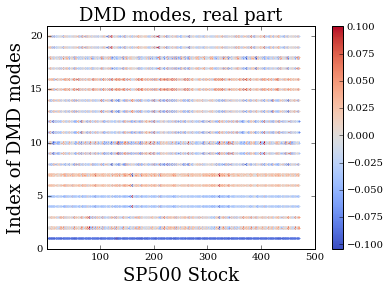

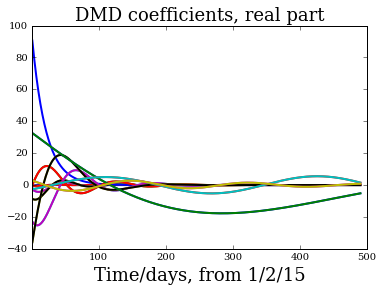

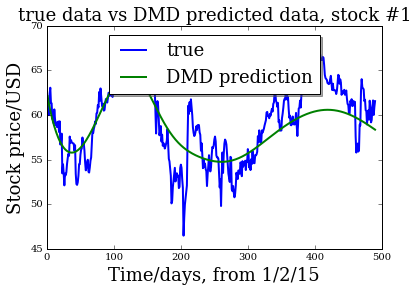

In [33]:
# call and test DMD
n_components = 20
SPreduction = reduction.Reduction(x)
evals, modes, energy_content = SPreduction.DMD(n_components)

# continuous time DMD eigenvalues
dt = 1./365
evalsCont = np.log(evals)/dt
theta = np.linspace(0,2*np.pi,1000)

# plot DMD eigenvalues
plt.figure()
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.scatter(evals.real, evals.imag, marker='x', linewidth=2,s=100, label='DMD eigenvalues')
plt.plot(np.cos(theta),np.sin(theta),'g-',linewidth=2,label='Unit circle')
plt.xlabel('Re', fontsize=18)
plt.ylabel('Im', fontsize=18)
plt.xlim([0.8,1.2])
plt.ylim([-0.2,0.2])
plt.legend(shadow=True, fontsize=18)
plt.title('Discrete-time DMD eigenvalues', fontsize=18)
plt.show()

# plot DMD modes
plt.figure()
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(n_components):
    plt.scatter(range(1,nStock+1),(i+1)*np.ones(nStock),c=modes[:,i].real, 
                marker='+', s=5, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlim([1,500])
plt.ylim([0,n_components+1])
plt.xlabel('SP500 Stock', fontsize=18)
plt.ylabel('Index of DMD modes', fontsize=18)
plt.title('DMD modes, real part', fontsize=18)
plt.show()

# DMD prediction, projection of initial condition to DMD modes
coeffs = np.linalg.pinv(modes).dot(x[:,0])
timeHorizon = nTime
xDMD = np.zeros((nStock,timeHorizon),dtype=complex)
coeffDMD = np.zeros((n_components,timeHorizon),dtype=complex)
for i in range(timeHorizon):
    coeffDMD[:,i] = coeffs*evals**i
    xDMD[:,i] = np.sum(coeffDMD[:,i]*modes,axis=1)

# plot real part, DMD modes coefficient with time
plt.figure()
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(n_components):
    plt.plot(range(1,timeHorizon+1), coeffDMD[i,:].real,'-',linewidth=2)
plt.xlim([1,500])
plt.xlabel('Time/days, from 1/2/15', fontsize=18)
plt.title('DMD coefficients, real part', fontsize=18)
plt.show()

# plot DMD prediction and true data
stockIndex = 1
stockMean = np.mean(SP500[stockIndex,:])
stockStd = np.std(SP500[stockIndex,:])
plt.figure()
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(range(1,timeHorizon+1), stockMean + stockStd*x[stockIndex,:timeHorizon],'-',linewidth=2,label='true')
plt.plot(range(1,timeHorizon+1), stockMean + stockStd*xDMD[stockIndex,:].real,'-',linewidth=2,label='DMD prediction')
plt.xlabel('Time/days, from 1/2/15', fontsize=18)
plt.ylabel('Stock price/USD', fontsize=18)
plt.title('true data vs DMD predicted data, stock #1', fontsize=18)
plt.legend(loc='upper center', shadow=True, fontsize=18)
plt.show()